In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

from sklearn.model_selection import train_test_split
import xgboost as xgb

import matplotlib.pyplot as plt

from data_generator import DataStatistics, DataGenerator

#!pip install unhcrpyplotstyle

In [10]:
class ModelManager:
    def __init__(self, base_path: str = '../models/'):
        self.base_path = base_path

    def train_models(self, df: pd.DataFrame, feature_col: str, target_cols: list, scope: str, model: str = 'XGB') -> dict:
        """ Loads in model for the specified feature column and fit over training data. """
        scope_pathname = self._get_scope_pathname(scope)
        path = f"{self.base_path}{model}_{scope_pathname}_model.p"
        fitted_models = {}
        X = df[feature_col].values
        
        for target_col in target_cols:
            y = df[target_col].values
            loaded_model = pickle.load(open(path, "rb"))
            loaded_model.fit(X, y)
            fitted_models[target_col] = loaded_model
        
        return fitted_models

    @staticmethod
    def _get_scope_pathname(scope: str) -> str:
        """ Determines the file path suffix based on the emission scope. """
        if scope == 'Scope 1':
            return 'scope1'
        elif scope == 'Scope 2':
            return 'scope2'
        else:
            return 'total_emissions'


class EmissionsForecaster:
    """ Forecasts future emissions based on trained models and trends. """
    def __init__(self, num_years_forecast: int = 6, growth_mean: float = 0.3, growth_std: float = 0.5):
        self.num_years_forecast = num_years_forecast
        self.growth_mean = growth_mean
        self.growth_std = growth_std

    def forecast_emissions(self, models: dict, last_year_data: dict):
        """ Produces a forecast of emissions for the specified number of future years. """
        future_data = self.apply_macro_trends(last_year_data)
        processed_data = self.model_predict(models, future_data)
        return pd.DataFrame(processed_data, index=np.arange(2023, 2023 + self.num_years_forecast))

    def apply_macro_trends(self, last_year_data: dict) -> dict:
        """ Applies macro trends to the last year's data to forecast future data points. """
        future_data = {}
        for data_type, last_year_value in last_year_data.items():
            growth_rates = np.random.normal(loc=self.growth_mean, scale=self.growth_std, size=self.num_years_forecast)
            future_values = [last_year_value]
            for idx, growth_rate in enumerate(growth_rates):
                year = 2023 + idx
                legislative_impact = self._apply_legislative_impacts(year)
                future_value = future_values[-1] * (1 + growth_rate) * legislative_impact
                future_values.append(future_value)
            future_data[data_type] = future_values[1:]
        return future_data

    def model_predict(self, models: dict, future_data: dict) -> dict:
        """ Applies emissions-specific models to forecast data. """
        df_future_data = pd.DataFrame(future_data, index=np.arange(2023, 2023 + self.num_years_forecast))
        emissions_data = {}
        for emission_type, model in models.items():
            predicted_emissions = []
            for year_index, row in df_future_data.iterrows():
                inputs = row.values.reshape(1, -1)
                emissions = model.predict(inputs)
                emissions = self.apply_sector_trends(emissions, emission_type, year_index)
                predicted_emissions.append(emissions)
            emissions_data[emission_type] = predicted_emissions
        return emissions_data
    
    def apply_sector_trends(self, emissions: float, emission_type: str, year_index: int) -> float:
        """  Adjusts predictions based on projected emission-level trends. """
        factor = 1
        if emission_type == 'electricity':
            factor = 0.93
        elif emission_type == 'mobile_sources':
            factor = 1.1
        elif emission_type == 'business_travel':
            factor = 0.95
        elif emission_type == 'commuting':
            factor = 0.90
        elif emission_type == 'waste':
            factor = 1.1 
        emissions *= factor ** (year_index - 2023)
        return emissions[0]
    
    @staticmethod
    def _apply_legislative_impacts(year: int) -> float:
        """ Adjusts forecasts based on anticipated legislative impacts specific to each year. """
        policy_years = {
            2021: 0.95,  # Initial phase of Bipartisan Infrastructure Law
            2023: 0.90,  # Phase in of Senate Inflation Reduction Act
            2026: 0.85   # Full impact of House Build Back Better Act
        }
        # Find the latest applicable factor based on the year
        applicable_factor = 1.0  # default factor before any policy
        for policy_year, factor in sorted(policy_years.items(), reverse=True):
            if year >= policy_year:
                applicable_factor = factor
                break
        return applicable_factor


class PlotManager:
    def plot_scope_forecast(self, df: pd.DataFrame, scope: str, model_name='Gradient Boosting') -> None:
        """ Plots the forecasted emissions data with an area stackplot. """
        plt.style.use(['unhcrpyplotstyle', 'area'])  # Optional: custom matplotlib styling i found
        x = df.index
        fig, ax = plt.subplots()
        self.plot_stackplot(ax, df, x)  # Plot the stackplot
        self.draw_vert_line(ax)  # Draw the x-axis line indicating start of predictions
        self.plot_legend(ax, df)  # Plot the legend
        self.plot_titles(ax, scope)  # Set plot title/labels
        self.add_caption(x, model_name)  # Add caption at bottom
        self.add_annotations(ax)  # Add text & arrows to graph
        fig.tight_layout()
        plt.savefig(f"../output_graphs/{model_name}_{scope}_graph".replace(' ', '_'))
        plt.show()

    def plot_stackplot(self, ax, df, x, order='default'):
        if order == 'ascending':
            total_area = df.sum(axis=0)
            sorted_columns = total_area.sort_values().index
            labels = self.format_legend_labels(sorted_columns)
            ax.stackplot(x, *[df[col] for col in sorted_columns], 
                        labels=labels, alpha=0.8)
        else:
            labels = self.format_legend_labels(df.columns)
            ax.stackplot(x, 
                     *[df[col] for col in df.columns], 
                     labels=labels, 
                     alpha=0.8)

    def draw_vert_line(self, ax):
        """ Draws dotted vertical line indicating the start of predictions. """
        ax.axvline(x=2024, 
                   color='black', 
                   linestyle='--')
        
    def format_legend_labels(self, columns: list) -> list:
        """Format legend labels to look more readable/cleaner."""
        return [col.replace('_', ' ').capitalize() for col in columns]

    def plot_legend(self, ax, df):
        """ Adds a legend & dynamically adjusts the number of columns. """
        if len(df.columns) <= 4:
            num_cols = len(df.columns)
        else:
            num_cols = np.ceil(len(df.columns) / 2).astype(int)
        ax.legend(loc=(0, 1.05), ncol=num_cols)

    def plot_titles(self, ax, scope):
        """ Sets the title and labels for the plot. """
        ax.set_title(f'Forecast of {scope} Emissions for the Next 5 Years', pad=50)
        ax.set_ylabel('Emissions (MT CO2e)')

    def add_annotations(self, ax):
        """ Adds text annotations and arrows to plot. """
        prediction_start_year = 2024
        y_pos = ax.get_ylim()[1] * 0.1
        text_properties = {'xycoords': 'data', 'textcoords': 'offset points', 'va': 'center', 'color': 'black'}

        # Text annotation
        ax.annotate('Historical', xy=(prediction_start_year + 0.5, y_pos), xytext=(-55, -15),
                    ha='right', fontsize=10, **text_properties)
        ax.annotate('Projected', xy=(prediction_start_year - 0.5, y_pos), xytext=(55, -15),
                    ha='left', fontsize=10, **text_properties)

        # Arrows
        ax.annotate('', xy=(prediction_start_year - 0.55, y_pos), xytext=(35, 0),
                    arrowprops=dict(arrowstyle="->", color='black'), ha='center', **text_properties)
        ax.annotate('', xy=(prediction_start_year + 0.55, y_pos), xytext=(-35, 0),
                    arrowprops=dict(arrowstyle="->", color='black'), ha='center', **text_properties)

    def add_caption(self, x, model_name):
        """ Adds caption at the bottom of the figure. """
        plt.xticks(x,x)
        plt.annotate(f"Forecast based on {model_name} Model", 
                     (0,0), 
                     (0, -40),
                     xycoords='axes fraction', 
                     textcoords='offset points',
                     va='top', 
                     fontsize=9, 
                     color='#666666')



**Assumptions:**
- Assuming that we will only have access to a single years worth of GHG emissons data (granulated at the year level)
- Assuming that we will eventually have access to multiple years worth of past business data such as revenue, number of employees, assets, etc


**Outline:**
1. Generate synthetic training data for the past 5 years of related business data (revenue, number of employees, assets, etc.).
2. Train a separate time series/statistical model for each variable on the synthetic data set.
3. Create a forecast/projection for each variable until 2030. 
4. Generate another synthetic training data set with business factors as predictors and GHG emissions as the target variables. 
5. Train a separate XGB model for each GHG emission.
6. Predict the GHG emissions using the forecasted business values.
7. Incorporate macro-level trends (i.e., climate bills) and projections (i.e., projected $CO_2$ emissions by sector/industry)


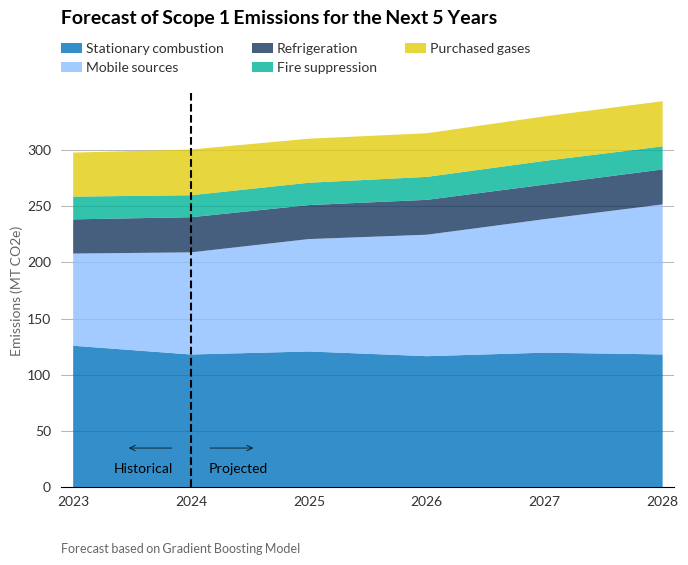

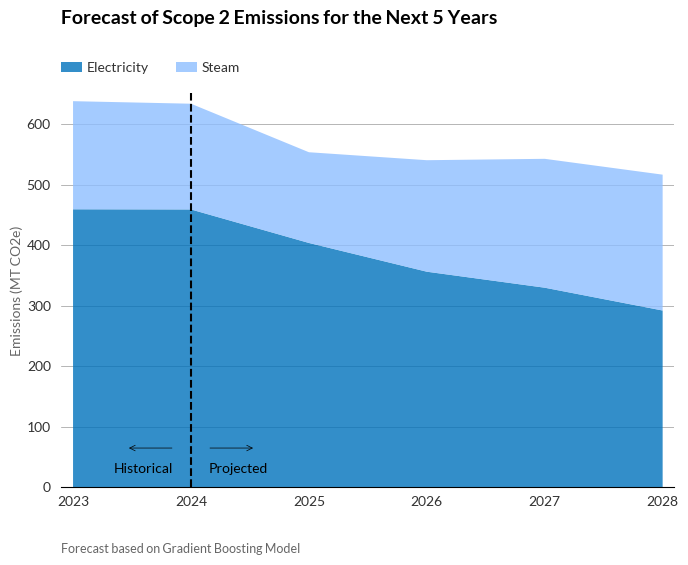

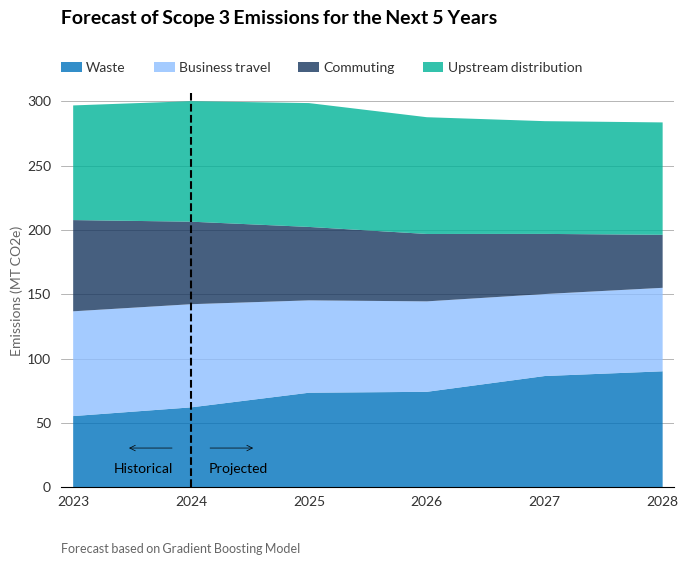

In [11]:
stats = DataStatistics()
data_generator = DataGenerator(stats)
model_manager = ModelManager()
forecast_manager = EmissionsForecaster()
plot_manager = PlotManager()

sample_data = data_generator.generate_example_data()
validation_features_dict = data_generator.generate_feature_vars().loc[0,:].to_dict()

variables_dict = {
    'Scope 1': ['stationary_combustion', 'mobile_sources', 'refrigeration', 'fire_suppression', 'purchased_gases'],
    'Scope 2': ['electricity', 'steam'], 
    'Scope 3': ['waste', 'business_travel', 'commuting', 'upstream_distribution']
}

for scope, emissions in variables_dict.items():
    new_features = stats.get_feature_keys()
    models = model_manager.train_models(df=sample_data, feature_col=new_features, target_cols=emissions, scope=scope)
    emissions_forecast = forecast_manager.forecast_emissions(models, validation_features_dict)
    plot_manager.plot_scope_forecast(emissions_forecast, scope)